In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets


In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mantasu/face-attributes-grouped")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chathui3628
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mantasu/face-attributes-grouped


100%|██████████| 1.50G/1.50G [00:08<00:00, 183MB/s]


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

In [5]:
# 2. CONFIG
# =====================================
BASE_DIR = '/content/face-attributes-grouped/face-attributes-grouped'

TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR   = os.path.join(BASE_DIR, 'val')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 25
EPOCHS_FINE = 75

CATEGORY = 'nowear'
CLASSES = ['facemarks', 'facepaint', 'facialhair', 'plain']


In [6]:
# 3. DATA GENERATORS (NO AUGMENTATION)
# =====================================
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(TRAIN_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(VAL_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(TEST_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [7]:
# 4. CLASS WEIGHTS
# =====================================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


In [8]:
# 5. MODEL (Xception @224)
# =====================================
def build_model(num_classes):
    base = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base.trainable = False   # phase 1

    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(base.input, outputs)


model = build_model(len(CLASSES))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
# 6. PHASE 1 – TRAIN HEAD
# =====================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb1 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3),
    ModelCheckpoint("best_nowear_head_224.h5", save_best_only=True)
]

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_HEAD,
    class_weight=class_weights,
    callbacks=cb1
)

# 7. PHASE 2 – FINE TUNE (TOP 30 LAYERS)
# =====================================
model.load_weights("best_nowear_head_224.h5")

for layer in model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb2 = [
    EarlyStopping(patience=7, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.3),
    ModelCheckpoint("best_nowear_final_224.h5", save_best_only=True)
]

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    class_weight=class_weights,
    callbacks=cb2
)


Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5448 - loss: 1.4143

125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 276ms/step - accuracy: 0.5452 - loss: 1.4126 - val_accuracy: 0.7350 - val_loss: 0.7600 - learning_rate: 0.0010
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7054 - loss: 0.7712

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.7053 - loss: 0.7714 - val_accuracy: 0.7550 - val_loss: 0.7100 - learning_rate: 0.0010
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7455 - loss: 0.6763

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.7455 - loss: 0.6763 - val_accuracy: 0.7450 - val_loss: 0.6694 - learning_rate: 0.0010
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.7776 - loss: 0.5782 - val_accuracy: 0.7375 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.7856 - loss: 0.5751 - val_accuracy: 0.7500 - val_loss: 0.6766 - learning_rate: 0.0010
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.7988 - loss: 0.4963 - val_accuracy: 0.7650 - val_loss: 0.6793 - learning_rate: 0.0010
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8301 - loss: 0.4577

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.8300 - loss: 0.4578 - val_accuracy: 0.7600 - val_loss: 0.6622 - learning_rate: 3.0000e-04
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.8288 - loss: 0.4434 - val_accuracy: 0.7425 - val_loss: 0.6773 - learning_rate: 3.0000e-04
Epoch 9/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.8425 - loss: 0.4140 - val_accuracy: 0.7525 - val_loss: 0.6729 - learning_rate: 3.0000e-04
Epoch 10/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.8542 - loss: 0.3961 - val_accuracy: 0.7475 - val_loss: 0.6748 - learning_rate: 3.0000e-04
Epoch 11/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.8608 - loss: 0.3806 - val_accuracy: 0.7550 - val_loss: 0.6688 - learning_rate: 9.0000e-05
Epoch 12/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.8579 - loss: 0.3702 - val_accuracy: 0.7675 - val_loss: 0.6687 - learning_rate: 9.0000e-05
Epoch 1/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step 

125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 261ms/step - accuracy: 0.6977 - loss: 0.7662 - val_accuracy: 0.7200 - val_loss: 0.8589 - learning_rate: 1.0000e-05
Epoch 2/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7330 - loss: 0.6609

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - accuracy: 0.7332 - loss: 0.6605 - val_accuracy: 0.7275 - val_loss: 0.7859 - learning_rate: 1.0000e-05
Epoch 3/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7977 - loss: 0.5421

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.7977 - loss: 0.5420 - val_accuracy: 0.7600 - val_loss: 0.7011 - learning_rate: 1.0000e-05
Epoch 4/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8073 - loss: 0.4924

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.8074 - loss: 0.4922 - val_accuracy: 0.7525 - val_loss: 0.6685 - learning_rate: 1.0000e-05
Epoch 5/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8563 - loss: 0.4052

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.8562 - loss: 0.4054 - val_accuracy: 0.7675 - val_loss: 0.6487 - learning_rate: 1.0000e-05
Epoch 6/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8455 - loss: 0.4181

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.8455 - loss: 0.4180 - val_accuracy: 0.7850 - val_loss: 0.6330 - learning_rate: 1.0000e-05
Epoch 7/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8508 - loss: 0.3802

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.8509 - loss: 0.3802 - val_accuracy: 0.7825 - val_loss: 0.6242 - learning_rate: 1.0000e-05
Epoch 8/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8863 - loss: 0.3269

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.8863 - loss: 0.3270 - val_accuracy: 0.7925 - val_loss: 0.6140 - learning_rate: 1.0000e-05
Epoch 9/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.8894 - loss: 0.3111 - val_accuracy: 0.7875 - val_loss: 0.6202 - learning_rate: 1.0000e-05
Epoch 10/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.8953 - loss: 0.2795 - val_accuracy: 0.7925 - val_loss: 0.6145 - learning_rate: 1.0000e-05
Epoch 11/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9082 - loss: 0.2779

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.9082 - loss: 0.2779 - val_accuracy: 0.8000 - val_loss: 0.6131 - learning_rate: 1.0000e-05
Epoch 12/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9102 - loss: 0.2600

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.9103 - loss: 0.2600 - val_accuracy: 0.8000 - val_loss: 0.6096 - learning_rate: 1.0000e-05
Epoch 13/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.9233 - loss: 0.2301 - val_accuracy: 0.8100 - val_loss: 0.6129 - learning_rate: 1.0000e-05
Epoch 14/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.9287 - loss: 0.2194 - val_accuracy: 0.8050 - val_loss: 0.6132 - learning_rate: 1.0000e-05
Epoch 15/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.9392 - loss: 0.1836 - val_accuracy: 0.8100 - val_loss: 0.6176 - learning_rate: 1.0000e-05
Epoch 16/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.9317 - loss: 0.1907 - val_accuracy: 0.8175 - val_loss: 0.6133 - learning_rate: 1.0000e-05
Epoch 17/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.9474 - loss: 0.1610 - val_accuracy: 0.8100 - val_loss: 0.6206 - learning_rate: 3.0000e-06
Epoch 18/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/s

In [11]:
# 8. FINAL TEST
# =====================================
test_loss, test_acc = model.evaluate(test_gen, verbose=0)

print("\n===============================")
print(f"FINAL TEST ACCURACY: {test_acc*100:.2f}%")
print("===============================")


FINAL TEST ACCURACY: 77.25%


In [13]:
# =====================================
# 8. DISPLAY TRAIN / VAL / TEST ACCURACY
# =====================================

# Evaluate on training set
train_loss, train_acc = model.evaluate(train_gen, verbose=0)

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_gen, verbose=0)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen, verbose=0)


print("\n===============================")
print("FINAL MODEL PERFORMANCE")
print("===============================")
print(f"Train Accuracy      : {train_acc*100:.2f}%")
print(f"Validation Accuracy : {val_acc*100:.2f}%")
print(f"Test Accuracy       : {test_acc*100:.2f}%")
print("===============================")



FINAL MODEL PERFORMANCE
Train Accuracy      : 98.77%
Validation Accuracy : 80.00%
Test Accuracy       : 77.25%


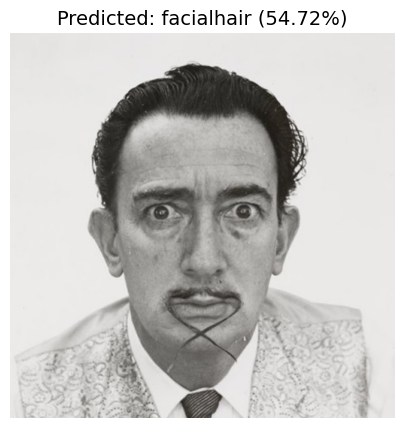

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# =========================
# 1. LOAD IMAGE
# =========================
image_path = "/content/face-attributes-grouped/face-attributes-grouped/test/nowear/facialhair/1640_1460648902_800800.jpg"
img_bgr = cv2.imread(image_path)

if img_bgr is None:
    print("Cannot read image!")
else:
    # Convert to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # =========================
    # 2. PREPROCESS FOR MODEL
    # =========================
    input_size = (224, 224)  # match training
    img_resized = cv2.resize(img_rgb, input_size)
    img_array = img_resized.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # =========================
    # 3. LOAD MODEL
    # =========================
    # Make sure you have trained model path correct
    model = load_model("best_nowear_final_224.h5", compile=False)

    # =========================
    # 4. PREDICT
    # =========================
    CLASSES = ['facemarks','facepaint','facialhair','plain']
    probs = model.predict(img_array, verbose=0)[0]

    top_idx = np.argmax(probs)
    top_class = CLASSES[top_idx]
    top_conf = probs[top_idx]

    # =========================
    # 5. DISPLAY IMAGE WITH PREDICTION
    # =========================
    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Predicted: {top_class} ({top_conf*100:.2f}%)", fontsize=14)
    plt.show()


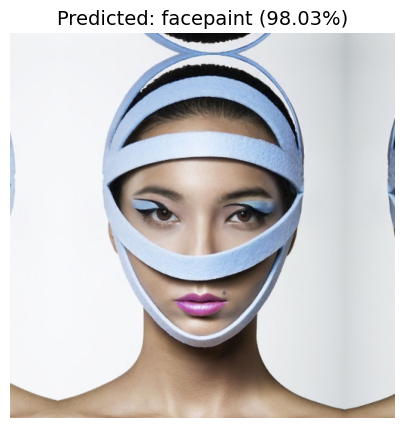

In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# =========================
# 1. LOAD IMAGE
# =========================
image_path = "/content/face-attributes-grouped/face-attributes-grouped/test/nowear/facepaint/11A9128-59a57fe6a046c-png__700.jpg"
img_bgr = cv2.imread(image_path)

if img_bgr is None:
    print("Cannot read image!")
else:
    # Convert to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # =========================
    # 2. PREPROCESS FOR MODEL
    # =========================
    input_size = (224, 224)  # match training
    img_resized = cv2.resize(img_rgb, input_size)
    img_array = img_resized.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # =========================
    # 3. LOAD MODEL
    # =========================
    # Make sure you have trained model path correct
    model = load_model("best_nowear_final_224.h5", compile=False)

    # =========================
    # 4. PREDICT
    # =========================
    CLASSES = ['facemarks','facepaint','facialhair','plain']
    probs = model.predict(img_array, verbose=0)[0]

    top_idx = np.argmax(probs)
    top_class = CLASSES[top_idx]
    top_conf = probs[top_idx]

    # =========================
    # 5. DISPLAY IMAGE WITH PREDICTION
    # =========================
    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Predicted: {top_class} ({top_conf*100:.2f}%)", fontsize=14)
    plt.show()


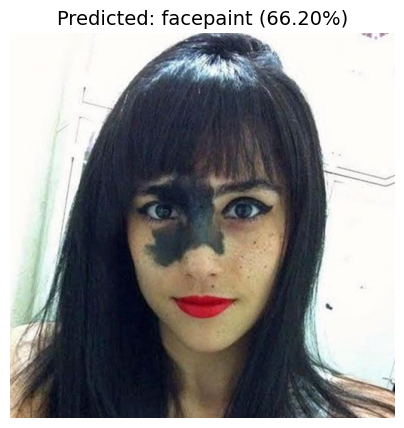

In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# =========================
# 1. LOAD IMAGE
# =========================
image_path = "/content/face-attributes-grouped/face-attributes-grouped/test/nowear/facemarks/03996e4527f1448d490d26cdde79476d.jpg"
img_bgr = cv2.imread(image_path)

if img_bgr is None:
    print("Cannot read image!")
else:
    # Convert to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # =========================
    # 2. PREPROCESS FOR MODEL
    # =========================
    input_size = (224, 224)  # match training
    img_resized = cv2.resize(img_rgb, input_size)
    img_array = img_resized.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # =========================
    # 3. LOAD MODEL
    # =========================
    # Make sure you have trained model path correct
    model = load_model("best_nowear_final_224.h5", compile=False)

    # =========================
    # 4. PREDICT
    # =========================
    CLASSES = ['facemarks','facepaint','facialhair','plain']
    probs = model.predict(img_array, verbose=0)[0]

    top_idx = np.argmax(probs)
    top_class = CLASSES[top_idx]
    top_conf = probs[top_idx]

    # =========================
    # 5. DISPLAY IMAGE WITH PREDICTION
    # =========================
    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Predicted: {top_class} ({top_conf*100:.2f}%)", fontsize=14)
    plt.show()
